In [1]:
!pip install -i https://test.pypi.org/simple/ mlutils --upgrade

Looking in indexes: https://test.pypi.org/simple/


In [2]:
import pandas as pd
from importlib import reload
from mlutils.preprocessing import preprocessing
from mlutils.tensorflowutils import tensorflowutils

In [3]:
reload(preprocessing)
reload(tensorflowutils)

<module 'mlutils.tensorflowutils.tensorflowutils' from '/home/alessiosavi/anaconda3/envs/ml/lib/python3.9/site-packages/mlutils/tensorflowutils/tensorflowutils.py'>

In [4]:
df = pd.read_csv(
    "dataset/jena_climate_2009_2016.zip", compression="zip", low_memory=False
)

In [5]:
df = df[["Date Time", "T (degC)"]]
df.head()

,Date Time,T (degC)
0,01.01.2009 00:10:00,-8.02
1,01.01.2009 00:20:00,-8.41
2,01.01.2009 00:30:00,-8.51
3,01.01.2009 00:40:00,-8.31
4,01.01.2009 00:50:00,-8.27


In [6]:
df = preprocessing.set_time_index(df, "Date Time", time_format="%d.%m.%Y %H:%M:%S")
del df["Date Time"]

In [7]:
df.info(verbose=True, memory_usage=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420551 entries, 2009-01-01 00:10:00 to 2017-01-01 00:00:00
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   T (degC)  420551 non-null  float64
dtypes: float64(1)
memory usage: 6.4 MB


In [8]:
df.head()

,T (degC)
Date Time,
2009-01-01 00:10:00,-8.02
2009-01-01 00:20:00,-8.41
2009-01-01 00:30:00,-8.51
2009-01-01 00:40:00,-8.31
2009-01-01 00:50:00,-8.27


In [9]:
# Resample to 1 day
df = preprocessing.resample_df(df, 86400)

df.info(verbose=True, memory_usage=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2923 entries, 2009-01-01 to 2017-01-01
Freq: 86400S
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   T (degC)  2923 non-null   float64
dtypes: float64(1)
memory usage: 45.7 KB


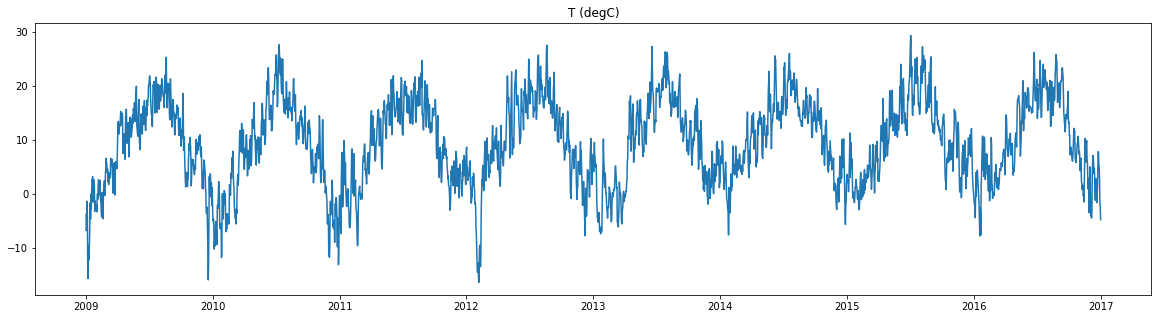

In [10]:
import matplotlib.pyplot as plt

for i in df.columns:
    plt.figure(figsize=(20, 5))
    plt.title(i)
    plt.plot(df[i])

In [11]:
df.describe()

,T (degC)
count,2923.000000
mean,9.438695
std,7.836859
min,-16.457292
25%,3.811007
50%,9.708333
75%,15.419062
max,29.375347


# TENSORFLOW

In [12]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy("mixed_float16")
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2080 Ti, compute capability 7.5


2021-11-24 20:50:51.550657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 20:50:51.554778: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 20:50:51.555549: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 20:50:51.556004: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [13]:
df.head()

,T (degC)
Date Time,
2009-01-01,-6.810629
2009-01-02,-3.728194
2009-01-03,-5.271736
2009-01-04,-1.375208
2009-01-05,-4.867153


## Scale data

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = {}
columns = {}
for column in df.columns:
    sc = StandardScaler()
    scaler[column] = sc
    df_scaled = sc.fit_transform(df[column].to_numpy().reshape(-1, 1))
    columns[column] = df_scaled.ravel()
# df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

,T (degC)
0,-2.073803
1,-1.680411
2,-1.877404
3,-1.380113
4,-1.825769


<AxesSubplot:>

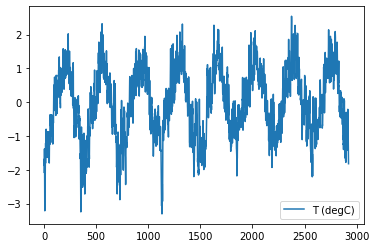

In [15]:
df_scaled = pd.DataFrame(columns)
display(df_scaled.head())
df_scaled.plot()

In [16]:
numpy_x = df_scaled.values
# numpy_x = df.values
# numpy_x = numpy_x.reshape(numpy_x.shape[0], 1)
numpy_x.shape

(2923, 1)

In [17]:
# Use 370 days as history, predict 7 days
history_window = 370
n_prediction = 7
n_features = numpy_x.shape[1]
df_x, df_y = preprocessing.split_sequence(numpy_x, history_window, n_prediction)

In [18]:
def get_predict_columns(df: pd.DataFrame, feature_name: str) -> int:
    for i in range(len(df.columns)):
        if df.columns[i] == feature_name:
            return i
    raise Exception("No column found")


feature_to_predict = get_predict_columns(df, "T (degC)")

In [19]:
df_y = df_y[:, :, feature_to_predict]

In [20]:
df_x.shape, df_y.shape

((2547, 370, 1), (2547, 7))

In [21]:
# Reshaping into n_example, timestamps, features
df_x = df_x.reshape(df_x.shape[0], df_x.shape[1])
df_x.shape

(2547, 370)

In [22]:
# Reshaping in n_example, timestamps
df_y = df_y.reshape(df_y.shape[0], df_y.shape[1])
df_y.shape

(2547, 7)

In [32]:
example_conf = """
{
    "model_type": "Sequential",
    "input_shape": [
        370
    ],
    "model_conf": [
        {
            "layer": "DENSE",
            "layer_conf": {
                "units": 128,
                "activation": "relu",
                "use_bias": true,
                "kernel_initializer": "glorot_uniform",
                "bias_initializer": "zeros"
            }
        },
        {
            "layer": "DENSE",
            "layer_conf": {
                "units": 64,
                "activation": "relu",
                "use_bias": true,
                "kernel_initializer": "glorot_uniform",
                "bias_initializer": "zeros"
            }
        },
        {
            "layer": "DROPOUT",
            "layer_conf": {
                "rate": 0.1
            }
        },
        {
            "layer": "DENSE",
            "layer_conf": {
                "units": 7,
                "activation": "",
                "use_bias": true,
                "kernel_initializer": "glorot_uniform",
                "bias_initializer": "zeros"
            }
        }
    ],
    "compile_conf": {
        "optimizer": "rmsprop",
        "loss": "mse",
        "metrics": "mae"
    }
}
"""

In [33]:
df_x[:-1].shape, df_y[:-1].shape

((2546, 370), (2546, 7))

In [34]:
import json
c = json.loads(example_conf)
callback = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=10, restore_best_weights=True
)
model = tensorflowutils.train_model(c,df_x[:-1], df_y[:-1],epochs=1000, callbacks=callback)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               47488     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 7)                 455       
                                                                 
Total params: 56,199
Trainable params: 56,199
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
80/80 [==============================] - 1s 2ms/step - loss: 0.4190 - mae: 0.5035
Epoch 2/1000
80/80 [==============================] - 0s 2ms/step - loss: 0.2809 - mae:

In [35]:
# Reshape input in order to have a single example with `history_window` timestamp
model_input = df_x[-1].reshape(1, history_window, n_features)

In [36]:
model_prediction = model.predict(model_input).ravel()

In [37]:
d = {
    "real_values": scaler["T (degC)"]
    .inverse_transform(df_y[-1].reshape(-1, 1))
    .ravel(),
    "model_values": scaler["T (degC)"]
    .inverse_transform(model_prediction.reshape(-1, 1))
    .ravel(),
}

<AxesSubplot:>

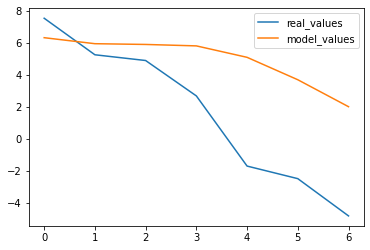

In [38]:
pd.DataFrame(d).plot()

In [31]:
model.save("my_model.h5")
model = tf.keras.models.load_model("my_model.h5")